# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose


# ToDo/Erkenntnisse
* Daten mit Woche 53 sind alle Null 

sj-Datensatz
* Es gibt Ausreißer z.B. zwischen 1995-11-01 - 1996-01-01
    * Die Ausreißer kommen davon, wenn eine Woche fehlt, z.B. Woche 52 von Jahr 2000
        *  Es gibt von Woche 52 nur 15 Einträge, alle anderen Wochen vollzählig
* Ab ca. Periode 200 sind Saisondaten unbrauchbar wegen Overfit
* Vor ca. Periode 25 sind Saisondaten unbrauchbar wegen Underfit


* Die Jahre mit fehlenden Wochen 52 (1993, 1999, 2005) haben aber Woche 53

Quelle der Datensätze: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

In [2]:
df_train = pd.read_csv("dataset/dengue_features_train.csv") 
df_labels = pd.read_csv("dataset/dengue_labels_train.csv")
df_labels_new = df_labels

Lösche alle Daten der Woche 53, da sie alle Null sind

In [3]:
df_labels_new = df_labels_new[df_labels_new['weekofyear'] != 53]

Konvertiere die Wochennummer und Jahre in Datetime-kompatible Daten für bessere Verarbeitung

In [4]:
df_labels_new['date'] = pd.to_datetime(df_labels_new['year'].astype(str) + df_labels_new['weekofyear'].astype(str) + '1',
                                       format='%Y%U%w')

C:\Users\rener\AppData\Local\Temp\ipykernel_15648\2434812637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_new['date'] = pd.to_datetime(df_labels_new['year'].astype(str) + df_labels_new['weekofyear'].astype(str) + '1',


Aufteilung des Dataframe in zwei verschiedene:
ein sj Dataframe für die Fälle der Stadt San Juan
ein iq Dataframe für die Fälle der Stadt Iquitos

In [5]:
df_sj_org = df_labels.loc[df_labels['city']=='sj']
df_iq_org = df_labels.loc[df_labels['city']=='iq']

df_sj = df_labels_new.loc[df_labels_new['city']=='sj']
df_iq = df_labels_new.loc[df_labels_new['city']=='iq']

Darstellung aller Fälle und ihren Zeitpunkt in San Juan in einem Graph

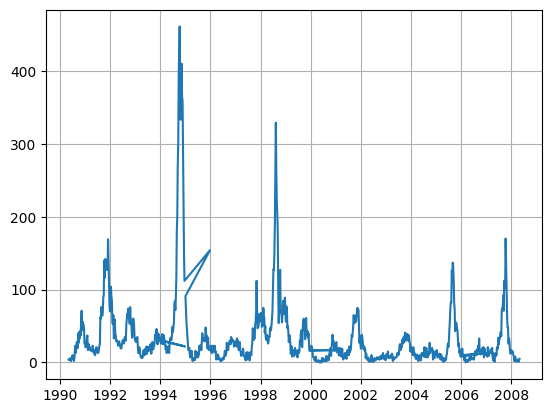

In [6]:
plt.plot(df_sj['date'],df_sj['total_cases'])
plt.grid()
plt.show()

Näherer Blick auf verschiedene Zeiträume

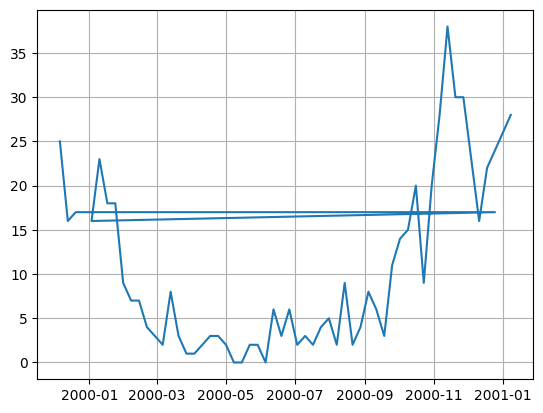

In [7]:
df_sj_time = df_sj[(df_sj['date'] >= '1999-12-01') & (df_sj['date'] <= '2001-01-08')]
plt.plot(df_sj_time['date'],df_sj_time['total_cases'])
plt.grid()
plt.show()

Zeige Daten in diesem Zeitraum

In [8]:
pd.set_option('display.max_rows', None)
print(df_sj_time)

    city  year  weekofyear  total_cases       date
500   sj  1999          49           25 1999-12-06
501   sj  1999          50           16 1999-12-13
502   sj  1999          51           17 1999-12-20
503   sj  2000          52           17 2000-12-25
504   sj  2000           1           16 2000-01-03
505   sj  2000           2           23 2000-01-10
506   sj  2000           3           18 2000-01-17
507   sj  2000           4           18 2000-01-24
508   sj  2000           5            9 2000-01-31
509   sj  2000           6            7 2000-02-07
510   sj  2000           7            7 2000-02-14
511   sj  2000           8            4 2000-02-21
512   sj  2000           9            3 2000-02-28
513   sj  2000          10            2 2000-03-06
514   sj  2000          11            8 2000-03-13
515   sj  2000          12            3 2000-03-20
516   sj  2000          13            1 2000-03-27
517   sj  2000          14            1 2000-04-03
518   sj  2000          15     

Zähle die Anzahl an Wochen. Es müssen bei jeder Woche 18 stehen, weil es 18 Jahre sind

In [9]:
for week in range(53):
    if(week!=0):
        print('Woche ' + str(week) + ': ' + str(df_sj['weekofyear'].value_counts()[week]))

Woche 1: 18
Woche 2: 18
Woche 3: 18
Woche 4: 18
Woche 5: 18
Woche 6: 18
Woche 7: 18
Woche 8: 18
Woche 9: 18
Woche 10: 18
Woche 11: 18
Woche 12: 18
Woche 13: 18
Woche 14: 18
Woche 15: 18
Woche 16: 18
Woche 17: 18
Woche 18: 18
Woche 19: 18
Woche 20: 18
Woche 21: 18
Woche 22: 18
Woche 23: 18
Woche 24: 18
Woche 25: 18
Woche 26: 18
Woche 27: 18
Woche 28: 18
Woche 29: 18
Woche 30: 18
Woche 31: 18
Woche 32: 18
Woche 33: 18
Woche 34: 18
Woche 35: 18
Woche 36: 18
Woche 37: 18
Woche 38: 18
Woche 39: 18
Woche 40: 18
Woche 41: 18
Woche 42: 18
Woche 43: 18
Woche 44: 18
Woche 45: 18
Woche 46: 18
Woche 47: 18
Woche 48: 18
Woche 49: 18
Woche 50: 18
Woche 51: 18
Woche 52: 15


Dekomposition der Fälle aus San Juan in Trend, Saison, Residual
Mehrmalige Dekomposition mit steigenden Betrachtungsperioden

In [10]:
#period = [25,50,75,100,150]
#for i in period:
#    result = seasonal_decompose(df_sj['total_cases'],period=i)
#    result.plot()
#    plt.title('Periode:' + str(i))
#    plt.show()

Analysiere, welche Tage die Daten sind

In [11]:
for i in df_sj['week_start_date']:
    datum_objekt = datetime.strptime(i, "%Y-%m-%d")
    tag = datum_objekt.day

KeyError: 'week_start_date'

1992-1993, 1998-1999, 2004-2005, 2009-2010
Problem: Woche 53 wird als Woche der darauf folgenden Jahre bezeichnet 